# Building and Retraining GANs using AnimeFace dataset

## Project Outline
#### This project delves into:
* The construction of a Generative Adversarial Network (GAN) using PyTorch.
* The process of loading pre-trained model parameters in PyTorch.
* The training and evaluation of your GAN within the PyTorch framework.

## Part 1. Importing Libraries and Downloading Resources
**This section sets up the environment and downloads necessary datasets and pre-trained weights.**

In [1]:
import argparse
import os
import random

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time

try:
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
except:
    pass

The following code automatically utilizes a CUDA device to accelerate code execution if a GPU is available, otherwise defaults to CPU.

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu') # Uncomment this line to force CPU usage

print('Device:', device)

Device: cuda:0


The [onedrivedownloader](https://pypi.org/project/onedrivedownloader/) package is utilized to download the dataset and pre-trained weights.

In [3]:
!pip install onedrivedownloader

In [4]:
from onedrivedownloader import download

link1 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/sjodeiri24_student_oulu_fi/EYHhY4vaYcZJqEY_4Nwo74YBU4nBT3a7_s7wwbtAnicvow?e=wDyN5L'

link2 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/sjodeiri24_student_oulu_fi/EfNw_RzyiahErfQ8RjGXMZQBP2tLi4B297B-ZMiZFOWrXw?e=UZmM2H'

if not os.path.exists('./data/anime'):
    print('Downloading the AnimeFace dataset')
    download(link1, filename='./anime.zip', unzip=True, unzip_path='./data/anime')

if not os.path.exists('./pretrained'):
    print('Downloading pre-trained weights')
    download(link2, filename='./gan_pretrained.zip', unzip=True, unzip_path='./pretrained')

100%|██████████| 21.5M/21.5M [00:03<00:00, 6.39MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 2000/2000 [00:00<00:00, 3219.17it/s]


100%|██████████| 2.01M/2.01M [00:01<00:00, 1.57MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 2/2 [00:00<00:00, 27.29it/s]


## Part 2. Building the Generative Adversarial Network

**The following content and figures are adapted from [Google's Machine Learning Crash Course on GANs](https://developers.google.com/machine-learning/gan).**

A [**Generative Adversarial Network (GAN)**](https://en.wikipedia.org/wiki/Generative_adversarial_network) is structured into two primary components:

* **Generator**: This component is tasked with learning to produce realistic data samples. These generated samples serve as negative training examples for the discriminator.

* **Discriminator**: This component learns to distinguish between genuine, real-world data and the synthetic data created by the generator. It provides feedback to the generator by penalizing it for producing outputs that are easily identifiable as fake.

<img src="https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg" width="650" style="float: left;">


<img src="https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg" width="650" style="float: left;">

Ideally, a well-trained generator will produce samples so realistic that the discriminator struggles to differentiate them from actual data, leading to a decrease in the discriminator's accuracy over fake samples.

<img src="https://developers.google.com/static/machine-learning/gan/images/good_gan.svg" width="650" style="float: left;">

The conceptual framework of a GAN is visually represented below:

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg" width="650" style="float: left;">

In the following sections, we implement a generator and discriminator inspired by the [DCGAN (Deep Convolutional Generative Adversarial Network)](https://arxiv.org/abs/1511.06434) architecture proposed by Radford et al. DCGAN provides architectural guidelines for stable GAN training, leveraging convolutional neural networks.

Key architectural guidelines from DCGAN include:
* Use strided convolutions in the discriminator and fractional-strided convolutions (transposed convolutions) in the generator to replace pooling layers.
* Avoid fully connected hidden layers in deeper network architectures.
* Employ ReLU activation in the generator for all layers except the output, which uses Tanh. Tanh helps the model quickly saturate and cover the color space of the training distribution.
* Use LeakyReLU activation in the discriminator across all layers.
* Apply batch normalization in both generator and discriminator, excluding the generator output layer and the discriminator input layer, to prevent instability and sample oscillation.

For in-depth information, please consult the original DCGAN paper.

While DCGAN is a foundational model from approximately a decade ago and more advanced GAN architectures exist today, it remains a valuable framework for understanding the fundamental principles of GANs, making it suitable for this project.

### 2.1 Building the Generator

The generator is designed to transform random noise into plausible images. It takes random noise vectors as input and outputs images.
- Input: A batch of random noise vectors of shape `(B, 100)`, reshaped to `(B, 100, 1, 1)` for convolutional operations.
- Output: A batch of generated RGB images of shape `(B, 3, 32, 32)` through a series of transposed convolutional layers that upscale the feature map resolution.

The architecture of the generator is depicted below:

<img src="http://yty.kapsi.fi/DLcourse/ass4/Generator.png" width="600" style="float: left;">

**Implementation Details:**
1. The `Generator` class inherits from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Define layers in `__init__()` and the forward pass logic in `forward()`.
2. PyTorch built-in classes are utilized; refer to their documentation for usage details.
    - `ConvTransposed` Layers: Implement using [`nn.ConvTranspose2d()`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) with specified `in_channels`, `out_channels`, `kernel_size`, `stride`, `padding`, and `bias=False` parameters, as per the architecture diagram.
    - `BN` Layers: Implement using [`nn.BatchNorm2d()`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) with `num_features` set to match the channel dimension.
    - Activation Functions: Use [`nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) for ReLU and [`nn.Tanh()`](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) for Tanh activations without parameters.

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Layers: inputs -> outputs, (B, C, H, W)

        # conv1: (B, 100, 1, 1) -> (B, 128, 4, 4)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=128, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )

        # conv2: (B, 128, 4, 4) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )

        # conv3: (B, 64, 8, 8) -> (B, 32, 16, 16)
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )

        # conv4: (B, 32, 16, 16) -> (B, 3, 32, 32)
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        return x

Verify the Generator Implementation.

In [6]:
# Create the generator
model_G = Generator().to(device)
print(model_G, '\n')

B = 2
noises = torch.randn((B, 100, 1, 1), device=device)
images = model_G(noises)

print('Shape of input:', noises.shape)
print('Shape of output:', images.shape)

Generator(
  (conv1): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
) 

Shape of input: torch.Size([2, 100, 1, 1])
Shape of output: torch.Size([2, 3, 32, 32])


Implementation Check: Generator Architecture and Output Shapes are verified.

### 2.2 Building the Discriminator

The discriminator's role is to classify input images as either real or fake. It receives batches of images and outputs a classification decision for each.
- Input: Batches of RGB images of shape `(B, 3, 32, 32)`.
- Output: Classifications as shape `(B, 1, 1, 1)`, flattened to `(B,)`, representing the probability of each image being real.

The architecture of the discriminator is detailed in the figure below:

<img src="http://yty.kapsi.fi/DLcourse/ass4/Discriminator.png" width="600" style="float: left;">

**Implementation Details:**
1. The `Discriminator` class, like the Generator, inherits from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Layers are defined in `__init__()`, and the forward computation in `forward()`.
2. Utilize PyTorch built-in classes; consult their documentation for proper implementation.
    - `Conv` Layers: Use [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with parameters like `in_channels`, `out_channels`, `kernel_size`, `stride`, `padding`, and `bias=False`, as per the architecture guide.
    - `BN` Layers: Use [`nn.BatchNorm2d()`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) setting `num_features` according to channel size.
    - Activation Functions: Implement LeakyReLU using [`nn.LeakyReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) with `negative_slope=0.2` and Sigmoid with [`nn.Sigmoid()`](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) without additional parameters.

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # Layers: inputs -> outputs, (B, C, H, W)

        # conv1: (B, 3, 32, 32) -> (B, 32, 16, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2),
        )

        # conv2: (B, 32, 16, 16) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2),
        )

        # conv3: (B, 64, 8, 8) -> (B, 128, 4, 4)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
        )

        # conv3: (B, 128, 4, 4) -> (B, 1, 1, 1)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.flatten()
        return x

Verify the Discriminator Implementation.

In [8]:
# Create the discriminator
model_D = Discriminator().to(device)
print(model_D, '\n')

B = 2
images = torch.randn((B, 3, 32, 32), device=device)
outputs = model_D(images)

print('Shape of input:', images.shape)
print('Shape of output:', outputs.shape)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
) 

Shape of input: torch.Size([2, 3, 32, 32])
Shape of output: torch.Size([2])


Implementation Check: Discriminator Architecture and Output Shapes confirmed.

### 2.3 Loading Pre-trained Weights

Load pre-trained weights for the Generator and Discriminator. These weights were pre-trained on the CelebA dataset.

Use [`torch.load()`](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-across-devices) to load pre-trained weights, ensuring the correct `device` is mapped for CPU or GPU usage using the `map_location` parameter.

In [9]:
def load_pretrained_weights(model_G, model_D, device, is_debug=False):
    weights_G_path = 'pretrained/weights_G.pth'
    weights_D_path = 'pretrained/weights_D.pth'

    weights_G = torch.load(weights_G_path, map_location=device, weights_only=True )
    weights_D = torch.load(weights_D_path, map_location=device, weights_only=True)

    model_G.load_state_dict(weights_G)
    model_D.load_state_dict(weights_D)


    if is_debug:
        print('The type of weights_D:\n', type(weights_D), '\n')
        print('The keys in weights_D:\n', list(weights_D.keys()), '\n')
        print('The shape of conv1.0 in weights_D:\n', weights_D['conv1.0.weight'].shape)

Run the following code to verify correct loading of weights. Successful execution without errors confirms correct generator and discriminator definitions.

In [10]:
model_G = Generator().to(device)
model_D = Discriminator().to(device)

load_pretrained_weights(model_G, model_D, device, is_debug=True)

The type of weights_D:
 <class 'collections.OrderedDict'> 

The keys in weights_D:
 ['conv1.0.weight', 'conv2.0.weight', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.weight', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'conv4.0.weight'] 

The shape of conv1.0 in weights_D:
 torch.Size([32, 3, 4, 4])


Output Verification: Successful loading is indicated by the type, keys, and shape of loaded weights.

Pretrained weights are loaded as a Python dictionary, with layer names as keys and weight tensors as values.

Visual comparison of image generation between randomly initialized and pre-trained generators follows.

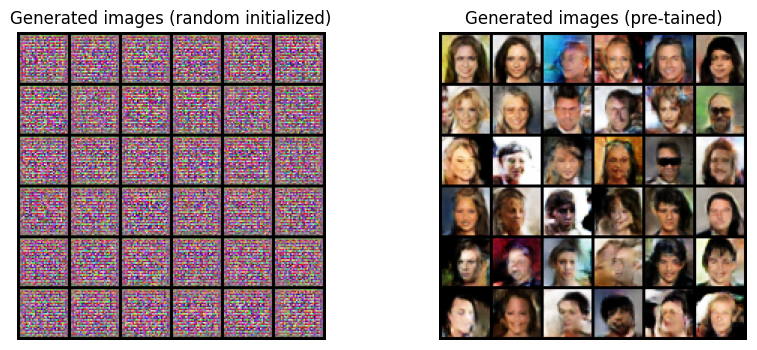

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Create the instances of Generator and Discriminator
model_G = Generator().to(device)
model_D = Discriminator().to(device)

# Create a set of fixed noise vectors for visualization
fixed_noise = torch.randn((36, 100, 1, 1), device=device)

# Generate images with the random initialized Generator and display them
generated_images = model_G(fixed_noise)
generated_images = utils.make_grid(generated_images.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[0].axis('off')
ax[0].set_title('Generated images (random initialized)')
ax[0].imshow(np.transpose(generated_images, (1, 2, 0)))

# Load the pre-trained weights for the Generator and Discriminator
load_pretrained_weights(model_G, model_D, device)

# Generate images with the pre-trained Generator and display them
generated_images_pretrained = model_G(fixed_noise)
generated_images_pretrained = utils.make_grid(generated_images_pretrained.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[1].axis('off')
ax[1].set_title('Generated images (pre-tained)')
ax[1].imshow(np.transpose(generated_images_pretrained, (1, 2, 0)))

Successful pre-weight loading is evidenced by face-like images on the right panel, compared to random noise in the left panel.

## Part 3. Retraining GAN on Anime Face Dataset

### 3.1 Preparing the Anime Face Dataset

Setting hyperparameters for data preprocessing and training. These parameters are pre-configured for optimal performance.

In [12]:
# Image size
image_size = 32

# Batch size for training
batch_size = 128
num_workers = 1

# Learning rate for optimizers
lr = 0.0002

# Number of training epochs
num_epochs = 30

Dataset and dataloader setup to load the AnimeFace dataset for retraining. The AnimeFace dataset will be used to fine-tune the pre-trained GAN models.

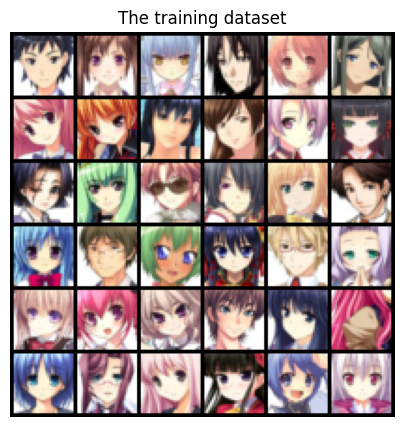

In [13]:
# Dataset creation using ImageFolder, assuming AnimeFace dataset structure is suitable
dataset = torchvision.datasets.ImageFolder(
    root='./data',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

# Dataloader creation for batching and shuffling the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Visualize a batch of training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The training dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))

`init_model_and_optimizer()` function encapsulates model initialization and optimization setup, using Binary Cross Entropy loss suitable for binary classification in GANs.

In [14]:
def init_model_and_optimizer():

    # Initialize Generator and Discriminator models
    model_G = Generator().to(device)
    model_D = Discriminator().to(device)

    # Load pre-trained weights
    load_pretrained_weights(model_G, model_D, device)

    # Optimizers setup for Generator and Discriminator with Adam
    optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(0.5, 0.999))

    # Binary Cross Entropy Loss function initialization
    BCE_loss = nn.BCELoss()

    return model_G, model_D, optimizer_G, optimizer_D, BCE_loss

In [15]:
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

### 3.2 Training Step for the Discriminator

Discriminator training data is sourced from:
- Real Images: Serve as positive examples for the discriminator.
- Fake Images: Generated by the generator and used as negative examples.

During training, the discriminator:
- Classifies real and generator-produced fake images.
- Computes loss based on its accuracy in distinguishing real from fake.
- Updates weights via backpropagation to improve its discrimination.

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram_discriminator.svg" width="650" style="float: left;">

Implementation of the discriminator training step function:

In [16]:
def training_step_D(
    real_images,
    model_G: nn.Module,
    model_D: nn.Module,
    optimizer_D: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Discriminator.

    Args:
        real_images: a batch of real image data from the training dataset
        model_G: the generator model
        model_D: the discriminator model
        optimizer_D: optimizer of the Discriminator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_D: the discriminator loss

    """

    # Reset the gradients of all parameters in discriminator
    model_D.zero_grad()

    batch_size = real_images.shape[0]

    # Prepare the real images and their labels
    real_images = real_images.to(device)
    real_labels = torch.ones((batch_size, ), device=device)

    # Prepare the fake images and their labels using the generator and the random `noise` created below
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)
    fake_labels = torch.zeros((batch_size, ), device=device)

    # Call `model_D()` and `BCE_loss` to calculate the losses for real and fake images
    real_outputs = model_D(real_images)
    loss_D_real = BCE_loss(real_outputs, real_labels)

    fake_outputs = model_D(fake_images)
    loss_D_fake = BCE_loss(fake_outputs, fake_labels)


    # Sum the loss of both real images and fake images to get the total discriminator loss.
    loss_D = loss_D_real + loss_D_fake

    # Compute the gradients
    loss_D.backward()

    # Update the parameters of `model_D`
    optimizer_D.step()

    if is_debug:
        print('Shape of real outputs:\n', real_outputs.shape, '\n')
        print('Shape and samples of real labels:\n', real_labels.shape, ' ', real_labels[:5], '\n')

        print('Shape of fake outputs:\n', fake_outputs.shape, '\n')
        print('Shape and samples of fake labels:\n', fake_labels.shape, ' ', fake_labels[:5], '\n')

    return loss_D

Verify the Discriminator Training Step Implementation.

In [17]:
torch.manual_seed(0)

batch_data = torch.randn((batch_size, 3, 32, 32), device=device)
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_D = training_step_D(batch_data, model_G, model_D, optimizer_D, BCE_loss, is_debug=True)
print('Discriminator loss:\n', loss_D)

Shape of real outputs:
 torch.Size([128]) 

Shape and samples of real labels:
 torch.Size([128])   tensor([1., 1., 1., 1., 1.], device='cuda:0') 

Shape of fake outputs:
 torch.Size([128]) 

Shape and samples of fake labels:
 torch.Size([128])   tensor([0., 0., 0., 0., 0.], device='cuda:0') 

Discriminator loss:
 tensor(11.4013, device='cuda:0', grad_fn=<AddBackward0>)


Implementation Check: Discriminator Training Step output and shapes verified.

### 3.3 Training Step for the Generator

Generator training integrates the generator and discriminator closely:
- Input: Random noise.
- Process: Noise is fed to the Generator to create a synthetic image, which is then evaluated by the Discriminator.
- Loss: Generator loss encourages the generator to create images that the discriminator mistakenly classifies as real.

The goal of the generator training step is to penalize the generator when its output is correctly identified as fake by the discriminator. We want the discriminator to classify the generated images as real during generator training, hence guiding the generator towards producing more realistic outputs.

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram_generator.svg" width="650" style="float: left;">

Implementation of the generator training step function:

In [18]:
def training_step_G(
    model_G: nn.Module,
    model_D: nn.Module,
    optimizer_G: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Generator.

    Args:
        model_G: the generator model
        model_D: the discriminator model
        optimizer_G: optimizer for the generator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_G: the generator loss

    """

    # Reset the gradients of all parameters in `model_G`
    model_G.zero_grad()

    # Generate fake images from `model_G` with random noises
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)


    # Prepare labels for fake_images
    labels = torch.ones((batch_size, ), device=device)


    # Call `model_D()` and `BCE_loss` to calculate the loss of Generator
    outputs = model_D(fake_images)
    loss_G = BCE_loss(outputs, labels)


    # Compute the gradients
    loss_G.backward()

    # Update the parameters of `model_G`
    optimizer_G.step()

    if is_debug:
        print('Shape of outputs:\n', outputs.shape, '\n')
        print('Shape of labels:\n', labels.shape, '\n')

    return loss_G

Verify the Generator Training Step Implementation.

In [19]:
torch.manual_seed(0)

model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_G = training_step_G(model_G, model_D, optimizer_G, BCE_loss, is_debug=True)

Shape of outputs:
 torch.Size([128]) 

Shape of labels:
 torch.Size([128]) 



Implementation Check: Generator Training Step output and shapes verified.

### Question: Why are real images excluded from generator training?

**Answer:** Training the generator with real images would bias it towards replicating, not generating, realistic novel images from noise, which is the GAN's goal. Generator training focuses on improving image novelty and realism by receiving feedback from the discriminator.

### 3.4 Training and Evaluating the GAN

Complete the GAN training process in the code cell below. GPU acceleration is recommended for efficient training, significantly reducing epoch times compared to CPU-based training.

In [20]:
# Initialize models, optimizers, and loss function
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

# Tracking lists for losses and generated images
img_list = []
G_losses = []
D_losses = []
iters = 0

torch.random.seed()
start_time = time.time()

# Start training loop
print("Starting the training loop...")

for epoch in range(num_epochs):
    # Iterate through dataloader batches
    for i, (real_images, _) in enumerate(dataloader, 0):

        # Perform Discriminator and Generator training steps
        loss_D = training_step_D(real_images, model_G, model_D, optimizer_D, BCE_loss)
        loss_G = training_step_G(model_G, model_D, optimizer_G, BCE_loss)

        # Print training stats periodically
        if i % 50 == 0:
            print('[Epoch][Iter][{}/{}][{}/{}] Loss_D: {:.4f}, Loss_G: {:.4f}, Time: {:.2f} s'.format(
                epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_G.item(), time.time() - start_time))
            start_time = time.time()

        # Store losses for later visualization
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Generate and save sample images from Generator using fixed noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = model_G(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True, nrow=6))
        iters += 1

print("Training finished!")

Starting the training loop...
[Epoch][Iter][0/30][0/16] Loss_D: 2.0791, Loss_G: 0.9314, Time: 0.37 s
[Epoch][Iter][1/30][0/16] Loss_D: 0.0735, Loss_G: 4.1486, Time: 5.67 s
[Epoch][Iter][2/30][0/16] Loss_D: 0.0924, Loss_G: 3.9857, Time: 4.92 s
[Epoch][Iter][3/30][0/16] Loss_D: 0.4493, Loss_G: 0.2298, Time: 4.09 s
[Epoch][Iter][4/30][0/16] Loss_D: 0.1747, Loss_G: 4.7071, Time: 1.73 s
[Epoch][Iter][5/30][0/16] Loss_D: 0.1559, Loss_G: 2.7453, Time: 1.86 s
[Epoch][Iter][6/30][0/16] Loss_D: 0.5229, Loss_G: 2.4258, Time: 2.19 s
[Epoch][Iter][7/30][0/16] Loss_D: 0.2578, Loss_G: 3.5992, Time: 2.16 s
[Epoch][Iter][8/30][0/16] Loss_D: 0.4775, Loss_G: 2.2862, Time: 1.55 s
[Epoch][Iter][9/30][0/16] Loss_D: 0.4073, Loss_G: 3.0634, Time: 1.44 s
[Epoch][Iter][10/30][0/16] Loss_D: 0.3998, Loss_G: 2.4933, Time: 1.45 s
[Epoch][Iter][11/30][0/16] Loss_D: 0.3179, Loss_G: 2.7090, Time: 1.49 s
[Epoch][Iter][12/30][0/16] Loss_D: 0.8150, Loss_G: 5.6891, Time: 1.55 s
[Epoch][Iter][13/30][0/16] Loss_D: 0.3391, L

Visualize Generator and Discriminator Losses.

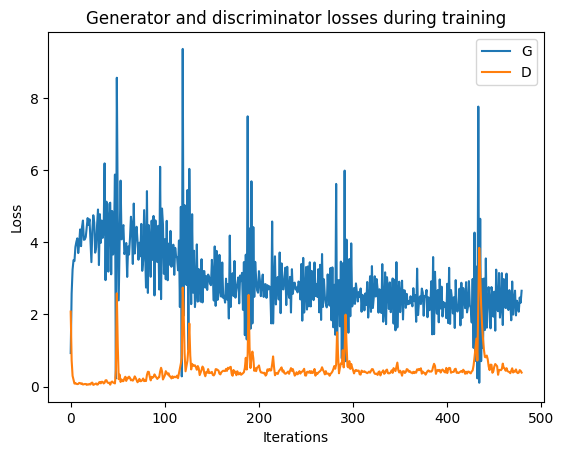

In [21]:
plt.figure()
plt.title("Generator and discriminator losses during training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Examine Generated Images after Training.

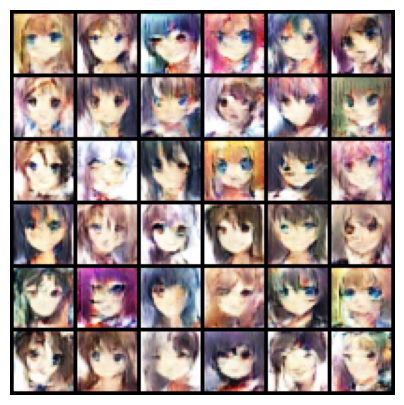

In [22]:
fig = plt.figure(figsize=(5, 5))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

Debugging Tip: If generated images are not as expected, revisit `training_step_G()` and `training_step_D()` implementations to ensure correctness.

Visualize the evolution of generated image quality over training iterations.

In [23]:
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())